In [1]:
import sympy
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import dill
from tqdm import tqdm
from triangle import triangulate
from utils import (
    fill_stiffness_matrix_bell_preconditioned,
    orient_batch,
    get_precondition_terms
)
from matplotlib import cm
dill.settings["recurse"] = True

### Get precomputed integrals

In [2]:
biharmonic_functional = dill.load(
    open("../calculations/bell_quintic_biharmonic_matrix_without_mixed_simplified", "rb")
)
basis_integral_values = dill.load(
    open("../calculations/bell_quintic_biharmonic_matrix_right_values_simplified", "rb")
)

### Initialize the domain

In [3]:
t = np.linspace(0, 1, 50, endpoint=False)
points = np.stack((np.cos(2*np.pi*t), np.sin(2*np.pi*t))).T

seg = np.array(
    [[j, j + 1] for j in range(points.shape[0] - 1)] + [[points.shape[0] - 1, 0]]
)

### Run triangulation

In [4]:
# S{n} - number of added steiner points

max_area = 0.01
min_angle = 30
order = 1

opts = f"pq{min_angle}a{max_area}o{order}en"

cndt = triangulate({"vertices": points, "segments": seg}, opts=opts)
points = cndt["vertices"]
triangles = cndt["triangles"]
edges = cndt["edges"]
neighbours = cndt["neighbors"]
vertex_marker_is_boundary = cndt["vertex_markers"]
edge_marker_is_boundary = cndt["edge_markers"]
print(
    f"Total number of points:\t\t{points.shape[0]}\nTotal number of elements:\t{triangles.shape[0]}"
)

Total number of points:		268
Total number of elements:	484


### Visualize triangulation

100%|██████████| 484/484 [00:00<00:00, 992200.95it/s]


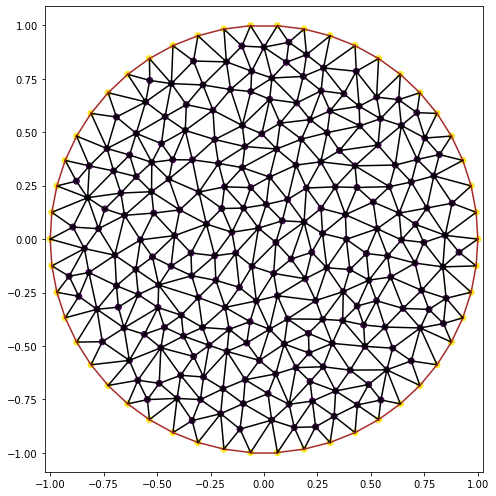

In [5]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(7, 7))
ax.axis("equal")

cl = ["black", "brown"]

for eidx, edge in enumerate(edges):
    ax.plot(
        points[edge][:, 0],
        points[edge][:, 1],
        color=cl[edge_marker_is_boundary[eidx][0]],
    )

ax.scatter(*points.T, c=vertex_marker_is_boundary)

xmn = points[:, 0].min()
xmx = points[:, 0].max()
ymn = points[:, 1].min()
ymx = points[:, 1].max()


ax.set_xlim([xmn, xmx])
ax.set_ylim([ymn, ymx])

PLOT_TRIANGLE_NUMBER = False
PLOT_VERTEX_NUMBER = False

for index, triangle in enumerate(tqdm(points[triangles])):
    if PLOT_TRIANGLE_NUMBER is True:
        ax.text(triangle[:, 0].mean(), triangle[:, 1].mean(), f"{index}")

if PLOT_VERTEX_NUMBER is True:
    eps = 1e-2
    for p_index, point in enumerate(points):
        ax.text(point[0] + eps, point[1] + eps, f"{p_index}", fontsize=15)

fig.tight_layout()

plt.show()

### Initialize variables

In [6]:
total_points = points.shape[0]
NUM = 6 * total_points

In [7]:
x, y = sympy.symbols("x y")

### Define the right part of the equation

In [8]:
F = sympy.Float(1)
F_x = F.diff(x)
F_y = F.diff(y)
F_xx = F_x.diff(x)
F_xy = F_x.diff(y)
F_yy = F_y.diff(y)

In [9]:
right_part_values = np.zeros((total_points, 6))
right_part_values[:, 0] = sympy.lambdify((x, y), F)(*points.T)
right_part_values[:, 1] = sympy.lambdify((x, y), F_x)(*points.T)
right_part_values[:, 2] = sympy.lambdify((x, y), F_y)(*points.T)
right_part_values[:, 3] = sympy.lambdify((x, y), F_xx)(*points.T)
right_part_values[:, 4] = sympy.lambdify((x, y), F_xy)(*points.T)
right_part_values[:, 5] = sympy.lambdify((x, y), F_yy)(*points.T)

### Stiffnes matrix assembling

In [10]:
triangles = orient_batch(triangles)
pts = points[triangles]

In [11]:
x1 = right_part_values[triangles[:, 0]]
x2 = right_part_values[triangles[:, 1]]
x3 = right_part_values[triangles[:, 2]]

In [12]:
cond = get_precondition_terms(points, triangles)

In [13]:
bilinear_form_ = biharmonic_functional(
    pts[:, 0, 0], pts[:, 0, 1],
    pts[:, 1, 0], pts[:, 1, 1],
    pts[:, 2, 0], pts[:, 2, 1]
).transpose(2, 0, 1)

right_part_ = basis_integral_values(
    pts[:, 0, 0], pts[:, 0, 1],
    pts[:, 1, 0], pts[:, 1, 1],
    pts[:, 2, 0], pts[:, 2, 1], 
    *x1.T, *x2.T, *x3.T
)[:, 0].T

In [14]:
bilinear_form_ = biharmonic_functional(
    pts[:, 0, 0], pts[:, 0, 1],
    pts[:, 1, 0], pts[:, 1, 1],
    pts[:, 2, 0], pts[:, 2, 1]
).transpose(2, 0, 1)

right_part_ = basis_integral_values(
    pts[:, 0, 0], pts[:, 0, 1],
    pts[:, 1, 0], pts[:, 1, 1],
    pts[:, 2, 0], pts[:, 2, 1], 
    *x1.T, *x2.T, *x3.T
)[:, 0].T

matrix = np.zeros((NUM, NUM), dtype=np.float64)
b = np.zeros((NUM), dtype=np.float64)

for bilinear_form, right_part, element in tqdm(zip(bilinear_form_, right_part_, triangles), total=len(triangles)):

    fill_stiffness_matrix_bell_preconditioned(
        matrix,
        b,
        bilinear_form,
        right_part,
        element,
        vertex_marker_is_boundary,
        cond
    )

100%|██████████| 484/484 [00:02<00:00, 200.84it/s]


### Visualize stiffness matrix

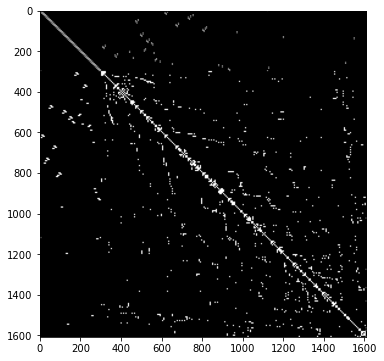

In [15]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(matrix != 0, cmap="gray")
plt.show()

### Solve the system

In [16]:
c = np.linalg.solve(matrix.astype(np.float32), b.astype(np.float32))

### Get values

In [17]:
_x_ = points[:, 0]
_y_ = points[:, 1]

U = (1 - x**2 - y**2)**2 / 64
U_x = sympy.lambdify((x, y), U.diff(x))(_x_, _y_)
U_y = sympy.lambdify((x, y), U.diff(y))(_x_, _y_)
U_xx = sympy.lambdify((x, y), U.diff(x, x))(_x_, _y_)
U_xy = sympy.lambdify((x, y), U.diff(x, y))(_x_, _y_)
U_yy = sympy.lambdify((x, y), U.diff(y, y))(_x_, _y_)
U = sympy.lambdify((x, y), U)(_x_, _y_)

F = c[0 :: 6]
Fx = c[1 :: 6] / cond
Fy = c[2 :: 6] / cond
Fxx = c[3 :: 6] / cond**2
Fxy = c[4 :: 6] / cond**2
Fyy = c[5 :: 6] / cond**2

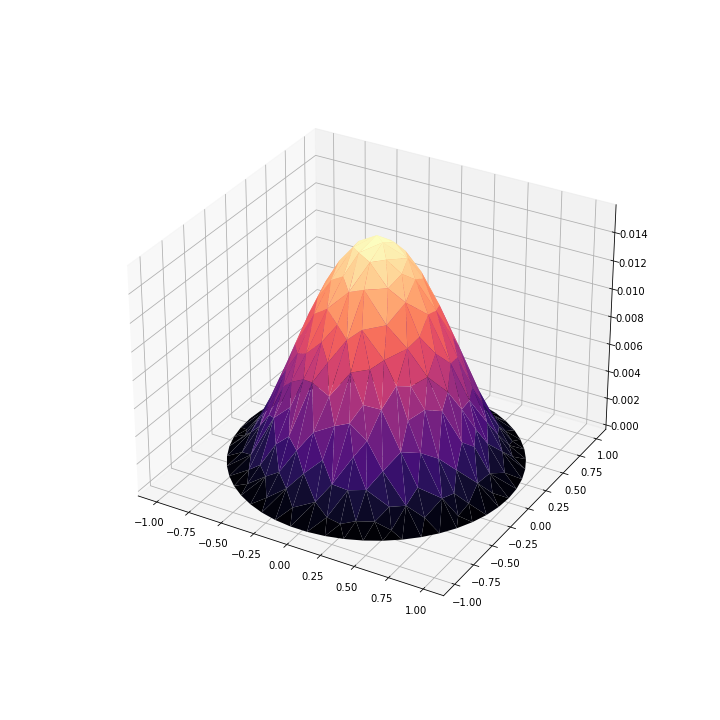

In [18]:
%matplotlib widget

fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection="3d"))
plot_1 = ax.plot_trisurf(_x_, _y_, F, triangles=triangles, cmap=cm.magma)

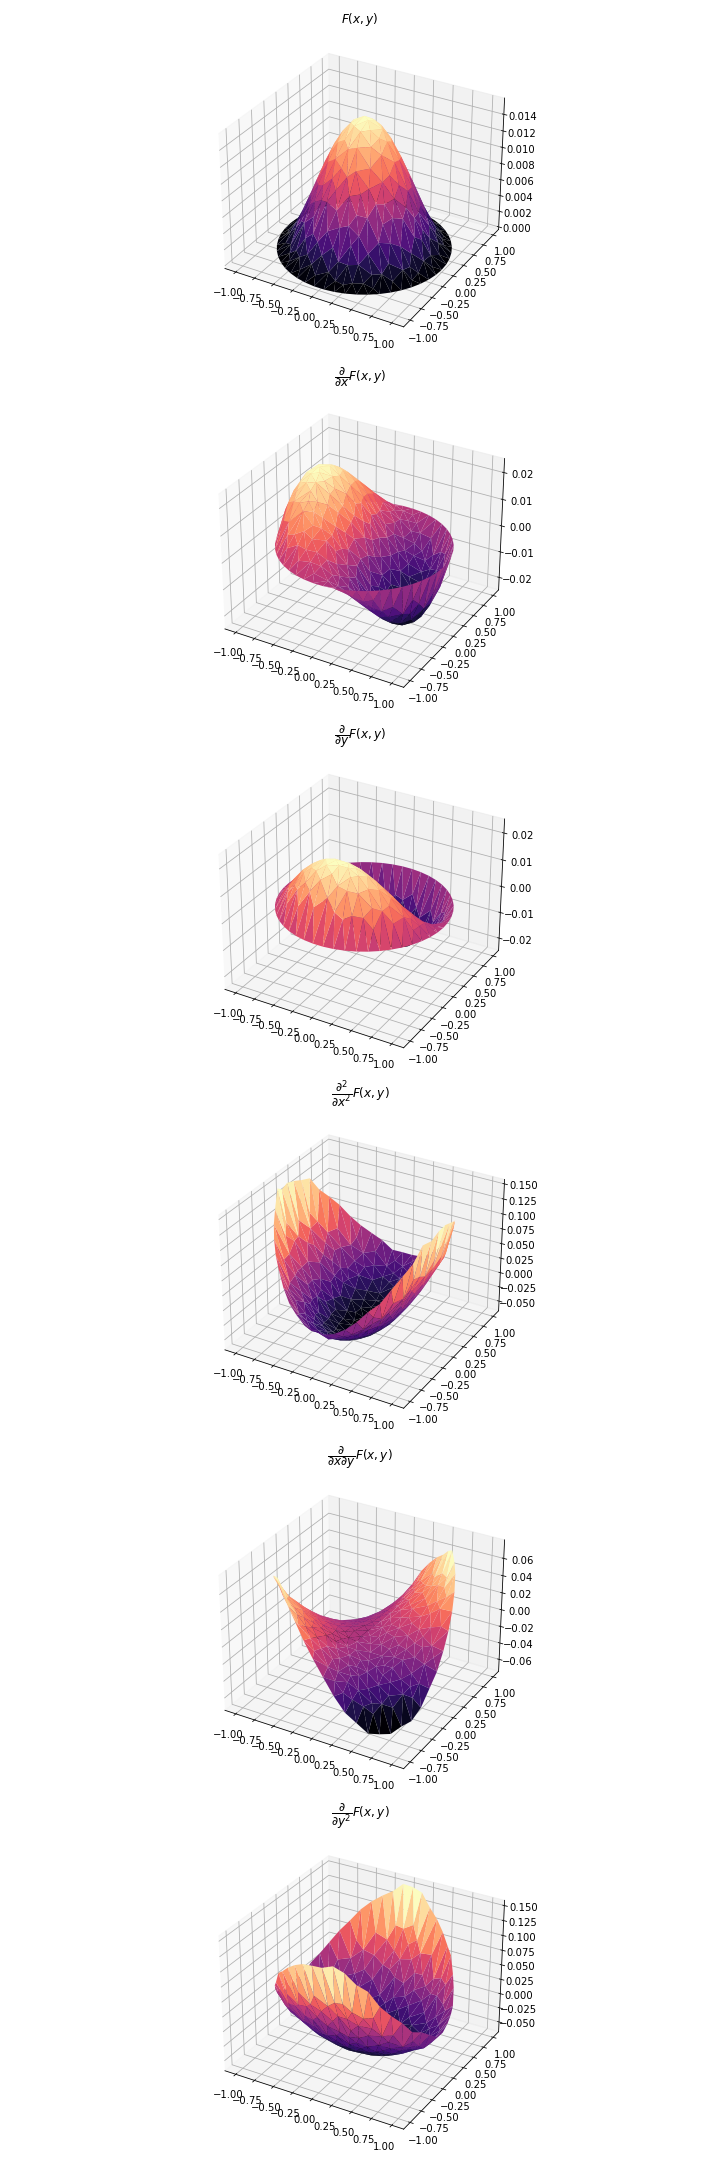

In [19]:
%matplotlib widget

fig, ax = plt.subplots(6, 1, figsize=(10, 30), subplot_kw=dict(projection="3d"))
plot_1 = ax[0].plot_trisurf(_x_, _y_, F, triangles=triangles, cmap=cm.magma)
ax[0].set_title(r"$F\left(x, y\right)$")
plot_2 = ax[1].plot_trisurf(_x_, _y_, Fx, triangles=triangles, cmap=cm.magma)
ax[1].set_title(r"$\dfrac{\partial}{\partial x}F\left(x, y\right)$")
plot_3 = ax[2].plot_trisurf(_x_, _y_, Fy, triangles=triangles, cmap=cm.magma)
ax[2].set_title(r"$\dfrac{\partial}{\partial y}F\left(x, y\right)$")
plot_4 = ax[3].plot_trisurf(_x_, _y_, Fxx, triangles=triangles, cmap=cm.magma)
ax[3].set_title(r"$\dfrac{\partial^{2}}{\partial x^{2}}F\left(x, y\right)$")
plot_5 = ax[4].plot_trisurf(_x_, _y_, Fxy, triangles=triangles, cmap=cm.magma)
ax[4].set_title(r"$\dfrac{\partial}{\partial x \partial y}F\left(x, y\right)$")
plot_6 = ax[5].plot_trisurf(_x_, _y_, Fyy, triangles=triangles, cmap=cm.magma)
ax[5].set_title(r"$\dfrac{\partial}{\partial y^{2}}F\left(x, y\right)$")
fig.tight_layout()
plt.show()

### Error

### $ \lVert F - \hat{F} \rVert_{\infty}$

In [20]:
abs(U - F).max()

9.52576891624611e-05

### $ \lVert F_{x} - \hat{F}_{x} \rVert_{\infty}$

In [21]:
abs(U_x - Fx).max()

0.0001921376211530875

### $ \lVert F_{y} - \hat{F}_{y} \rVert_{\infty}$

In [22]:
abs(U_y - Fy).max()

0.00019738778382533476

### $ \lVert F_{xx} - \hat{F}_{xx} \rVert_{\infty}$

In [23]:
abs(U_xx - Fxx).max()

0.03554986948345376

### $ \lVert F_{xy} - \hat{F}_{xy} \rVert_{\infty}$

In [24]:
abs(U_xy - Fxy).max()

0.015698300471721577

### $ \lVert F_{yy} - \hat{F}_{yy} \rVert_{\infty}$

In [25]:
abs(U_yy - Fyy).max()

0.02960049428564751

In [26]:
np.log10(np.linalg.cond(matrix))

6.567211232682377